In [1]:

from astropy.io import fits
import astropy.io.ascii # separate to not overwrite namespace 
from astropy.table import Column
from astropy import units as u
from scipy import optimize
from os.path import expanduser
# from ROOT import TRolke

%pylab inline
#%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
home = expanduser("~")
gc_dir = home + "/Dropbox/GalacticCenter/"


In [3]:
erg2TeV = (u.erg).to(u.TeV)
print(erg2TeV)

pylab.rcParams['figure.figsize'] = (12.0, 6.0)
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


0.624150934326018


In [8]:
# define our line fitting function
fitfunc = lambda p, x: p[0] + p[1] * (x)
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

# define our () fitting function
fitfuncECPL = lambda p, x: p[0] + p[1] * np.log(x) - (x) / p[2] # np.log is natural log  
errfuncECPL = lambda p, x, y, err: (np.log(y) - fitfuncECPL(p, x)) / (err)

fitfuncECPL_CF = lambda N0, gamma, beta, E: N0 + gamma*E - 1.*np.exp(E) / beta 


#these are just copied from http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html
f = lambda E, N0, E0, gamma: N0*(E/E0)**(-1.*gamma)
ferr = lambda E, F, N0, N0err, E0, cov_gg: \
                F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

f_ecpl = lambda E,N0,E0,gamma,beta: N0*(E/E0)**(-1.*gamma)*np.exp(-1.*E/beta)
ferr_ecpl = lambda E, F, N0, N0err, E0, cov_gg, b, cov_bb: \
F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2) * cov_gg + (E/E0)**2 / b**4 * cov_bb)

def plotPythonFit(energy, flux, flux_err_arg, color, name, ECPL=False, E0=1.):
    """fit flux points to a curve then plot"""
    
    if isinstance(flux_err_arg, tuple):
        flux_err = (flux_err_arg[1] + flux_err_arg[0]) / 2 
    else:
        flux_err = flux_err_arg 

    if ECPL:
        pinit = [-26, -2.25, 10]
        out = optimize.leastsq(errfuncECPL, pinit,
                               args=(energy/E0, flux, flux_err / flux), 
                               full_output=1)

    else:
        logx = np.log(energy/E0)
        logy = np.log(flux)
        logyerr = np.log(flux_err)

        pinit = [-26, -2.25] # nb ln
    
        out = optimize.leastsq(errfunc, pinit,
                               args=(logx, logy, logyerr), 
                               full_output=1)
    # end if else ECPL 

    pfinal = out[0]
    covar  = out[1]
    print("parameters:")
    print(pfinal)
    print("covariance matrix")
    print(covar)
    
    N0    = np.exp(pfinal[0])
    gamma = pfinal[1]
    E     = np.linspace(energy[0], energy[-1], num=100)
    
    if ECPL:
        beta = pfinal[2]
        
        F    = f_ecpl(E, N0, E0, -1.*gamma, beta)
        chi2 = np.sum((flux - f_ecpl(energy, N0, E0, -1.*gamma, beta))**2/flux_err**2) / (len(energy) - 3)
        print("chi^2: "+str(chi2)+'\n')
        beta_err  = np.sqrt( covar[2][2] ) * chi2 #* N0  
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        cov_bb = beta_err**2
        Ferr = ferr_ecpl(E, F, N0, N0_err, E0, cov_gg, beta, cov_bb)

        fitTitle = (name + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'G: {1:.2f} +- {3:.2f}, '\
                    'Ec: {4:.2f} +- {5:.2f}, '
                    'E0: {6:.0f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err),
                                          float(beta), float(beta_err), float(E0))

    else:
        F    = f(E, N0, E0, -1.*gamma)
        chi2 = np.sum((flux - f(energy, N0, E0, -1.*gamma))**2 / flux_err**2) / (len(energy) - 2)
        print(chi2)
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        Ferr = ferr(E, F, N0, N0_err, E0, cov_gg)
        
        fitTitle = (name + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'gamma: {1:.2f} +- {3:.2f}, '\
                    'E0: {4:.2f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err), float(E0))

    plt.plot(E, F * (E)**power, c=color, ls="--", marker="", label=fitTitle)
    plt.fill_between(E, (E)**power*(F+Ferr), (E)**power*(F-Ferr), color=color, alpha='0.25')
    plt.loglog(nonposy="clip")
    #plt.errorbar(energy, flux*energy**power, flux_err_arg, label=name, ls='')
    #plt.plot(E, F * (E)**power, ls="--", marker="", label=fitTitle)
    #plt.fill_between(E, (E)**power*(F+Ferr), (E)**power*(F-Ferr), alpha='0.25')

# end plotPythonFit 


In [5]:
def extract_points(filename):
    """"""
    with open(filename) as infile:
        # make dict 
        for line in iter(infile):
            line = line.split()
            try:
                float(line[0]) and float(line[3]) and float(line[4]) and float(line[5])
                H_energy = np.append(H_energy, float(line[0]))
                H_flux = np.append(H_flux, float(line[3]))
                H_err_up = np.append(H_err_up, float(line[4]))
                H_err_dwn = np.append(H_err_dwn, float(line[5]))
            except ValueError:
                continue 
# end extract SgrA spectral points from file     



# HESS Points

In [9]:
# SgrA spectral points and errors 
with open(gc_dir+"spectralPoints/HESS_SgrAstar_SpectralPoints_Bins.txt") as infile:
    H_energy = np.array([])
    H_flux = np.array([])
    H_err_up = np.array([])
    H_err_dwn = np.array([])
    for line in iter(infile):
        line = line.split()
        try:
            float(line[0]) and float(line[3]) and float(line[4]) and float(line[5])
            H_energy = np.append(H_energy, float(line[0]))
            H_flux = np.append(H_flux, float(line[3]))
            H_err_up = np.append(H_err_up, float(line[4]))
            H_err_dwn = np.append(H_err_dwn, float(line[5]))
        except ValueError:
            continue 
# end extract SgrA spectral points from file     

#"/spectralPoints/HESS_Diffuse_SpectralPoints_Bins.txt"


parameters:
[-26.70246008  -2.15662883  11.70791671]
covariance matrix
[[  9.62471330e-04   7.15355259e-04  -6.56259924e-02]
 [  7.15355259e-04   7.44671130e-04  -5.40581112e-02]
 [ -6.56259924e-02  -5.40581112e-02   5.79076641e+00]]
chi^2: 1.05253097649



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


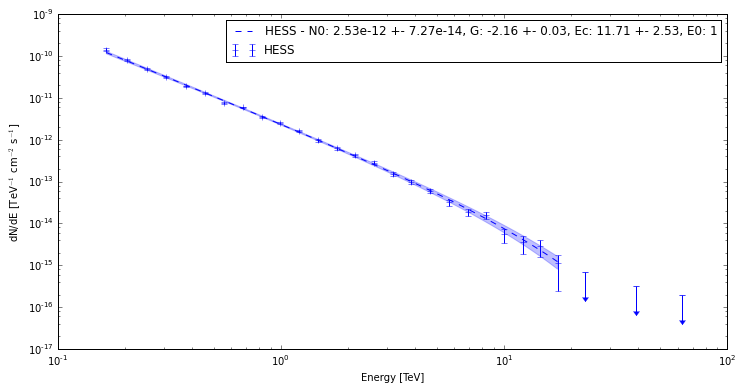

In [10]:
# dN/dE
power = 0.
plotPythonFit(H_energy[:-3], H_flux[:-3], (H_err_dwn[:-3],H_err_up[:-3]), 
              "blue", "HESS", ECPL=True)
# flux points
plt.errorbar(H_energy[:-3], H_flux[:-3], yerr=(H_err_dwn[:-3],H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
# upper limit points
plt.errorbar(H_energy[-3:], H_flux[-3:], yerr=(H_err_up[-3:],H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color = "blue")


plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"dN/dE [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]")


In [12]:
VEGAS_Points = """
2.499 6.62e-09 5.64e-10
3.96 1.61e-09 1.01e-10
6.273 4.9e-10 3.7e-11
9.935 1.49e-10 1.43e-11
15.73 4.3e-11 5.43e-12
24.87 6.44e-12 1.55e-12
35.37 5.29e-13 5.86e-13"""

V_Points_fine = astropy.io.ascii.read(VEGAS_Points)
# convert from m^-2 to cm^-2
V_Points_fine['col2'] *= 1e-4
V_Points_fine['col3'] *= 1e-4

V_Points_fine


col1,col2,col3
float64,float64,float64
2.499,6.62e-13,5.64e-14
3.96,1.61e-13,1.01e-14
6.273,4.9e-14,3.7e-15
9.935,1.49e-14,1.43e-15
15.73,4.3e-15,5.43e-16
24.87,6.44e-16,1.55e-16
35.37,5.29e-17,5.86e-17


parameters:
[-26.329634    -2.51879462  23.00245543]
covariance matrix
[[  1.92929336e-02  -2.22082519e-02   1.46858149e+00]
 [ -2.22082519e-02   3.19728595e-02  -2.48298846e+00]
 [  1.46858149e+00  -2.48298846e+00   2.18592261e+02]]
chi^2: 3.47284262228



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


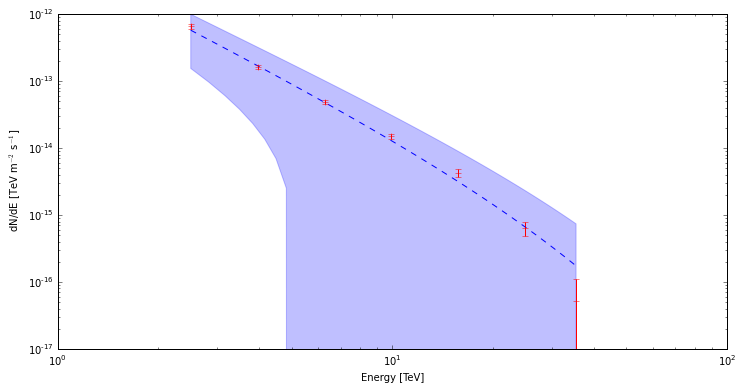

In [14]:
power = 0.
plotPythonFit(V_Points_fine['col1'], V_Points_fine['col2'], V_Points_fine['col3'], "blue", "HESS", ECPL=True, E0=1.25)
plt.errorbar(V_Points_fine['col1'], V_Points_fine['col2'] * V_Points_fine['col1']**power, 
             yerr = V_Points_fine['col3'] * V_Points_fine['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="red")
plt.loglog(nonposy="clip")
plt.ylim(ymin=1e-17)
plt.xlabel("Energy [TeV]")
plt.ylabel(r" dN/dE [TeV m$^{-2}$ s$^{-1}$]")


Combine 

In [26]:
# updated VEGAS points 
# highest energy bins 
VEGAS_Points = """
2.498 5.71e-09 4.03e-10
3.96 1.7e-09 1.08e-10
6.276 5.48e-10 4.15e-11
9.946 1.69e-10 1.69e-11
15.76 6.07e-11 7.63e-12
24.98 6.81e-12 2.67e-12
39.6 2.39e-13 7.91e-13 """

V_Points = astropy.io.ascii.read(VEGAS_Points)
# convert from m^-2 to cm^-2
V_Points['col2'] *= 1e-4 * erg2TeV
V_Points['col3'] *= 1e-4 * erg2TeV

V_Points


col1,col2,col3
float64,float64,float64
2.498,3.563901835e-13,2.51532826533e-14
3.96,1.06105658835e-13,6.74083009072e-15
6.276,3.42034712011e-14,2.59022637745e-15
9.946,1.05481507901e-14,1.05481507901e-15
15.76,3.78859617136e-15,4.76227162891e-16
24.98,4.25046786276e-16,1.66648299465e-16
39.6,1.49172073304e-17,4.93703389052e-17


parameters:
[-26.70246008  -2.15662883  11.70791671]
covariance matrix
[[  9.62471330e-04   7.15355259e-04  -6.56259924e-02]
 [  7.15355259e-04   7.44671130e-04  -5.40581112e-02]
 [ -6.56259924e-02  -5.40581112e-02   5.79076641e+00]]
chi^2: 1.05253097649



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


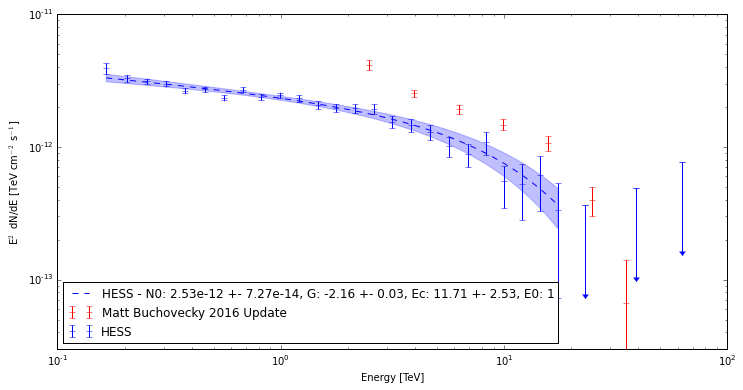

In [17]:
power = 2.
# fine binning 

# my VEGAS points
#plotPythonFit(V_Points['col1'], V_Points['col2'], V_Points['col3'], "HESS", "blue", ECPL=True, E0=1.0)
plt.errorbar(V_Points_fine['col1'], V_Points_fine['col2'] * V_Points_fine['col1']**power, 
             yerr = V_Points_fine['col3'] * V_Points_fine['col1']**power,
            label = "Matt Buchovecky 2016 Update", ls="", marker="+", color="red")

# HESS points
plotPythonFit(H_energy[:-3], H_flux[:-3], (H_err_dwn[:-3],H_err_up[:-3]), 
              "blue", "HESS", ECPL=True)
plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3], 
             yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
plt.errorbar(H_energy[-3:], H_energy[-3:]**2*H_flux[-3:], 
             yerr=(H_energy[-3:]**2*H_err_up[-3:], H_energy[-3:]**2*H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color = "blue")

# plot format 
plt.loglog(nonposy="clip")
plt.ylim(ymin=3e-14)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

# not saving 


In [36]:
Andy_Points = '''
2.813 3.44e-13 4.52e-14 
3.541 2.17e-13 2.43e-14
4.458 1.23e-13 1.37e-14
5.613 5.13e-14  7.4e-15
7.066 2.72e-14  4.3e-15
8.896 1.27e-14 2.48e-15
12.49  5.8e-15 8.86e-16
 19.8 1.44e-15 3.36e-16
31.39 1.22e-16 8.14e-17'''

A_Points = astropy.io.ascii.read(Andy_Points)
#A_Points['col2'] *= erg2TeV
#A_Points['col3'] *= erg2TeV

#A_Points


parameters:
[-26.70246008  -2.15662883  11.70791671]
covariance matrix
[[  9.62471330e-04   7.15355259e-04  -6.56259924e-02]
 [  7.15355259e-04   7.44671130e-04  -5.40581112e-02]
 [ -6.56259924e-02  -5.40581112e-02   5.79076641e+00]]
chi^2: 1.05253097649



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


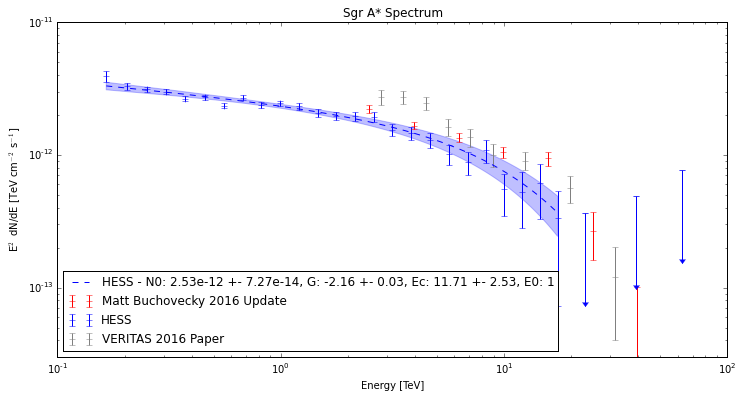

In [32]:
power = 2.

# my VEGAS points
#plotPythonFit(V_Points['col1'], V_Points['col2'], V_Points['col3'], "M2016", "red", ECPL=True, E0=1.0)
plt.errorbar(V_Points['col1'], V_Points['col2'] * V_Points['col1']**power, 
             yerr = V_Points['col3'] * V_Points['col1']**power,
             label = "Matt Buchovecky 2016 Update", ls="", marker="+", color="red")

# HESS points
plotPythonFit(H_energy[:-3], H_flux[:-3], (H_err_dwn[:-3],H_err_up[:-3]), 
              "blue", "HESS", ECPL=True)
plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3], 
             yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
plt.errorbar(H_energy[-3:], H_energy[-3:]**2*H_flux[-3:], 
             yerr=(H_energy[-3:]**2*H_err_up[-3:], H_energy[-3:]**2*H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color = "blue")

# Andy's points 

plt.errorbar(A_Points['col1'], A_Points['col2'] * A_Points['col1']**power, 
             yerr = A_Points['col3'] * A_Points['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="gray")

# plot format and save 
plt.title("Sgr A* Spectrum ")
plt.loglog(nonposy="clip")
plt.ylim(ymin=3e-14)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/SgrA_spectra_HESSoverlay_wAndy_ECPL.png")


<h2>G0.9+0.1

    col1      col2     col3     col4  
----------- -------- -------- --------
0.219663387 2.32e-11 3.17e-11  1.5e-11
0.366471541 8.03e-12 9.39e-12 6.52e-12
0.650552926 2.26e-12 2.64e-12  1.9e-12
1.164773919  6.7e-13 7.96e-13 5.63e-13
2.071088959 1.22e-13 1.64e-13 8.35e-14
3.886862492 1.52e-14 2.89e-14 4.38e-15
6.086655929 9.03e-15 1.49e-14 3.31e-15


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


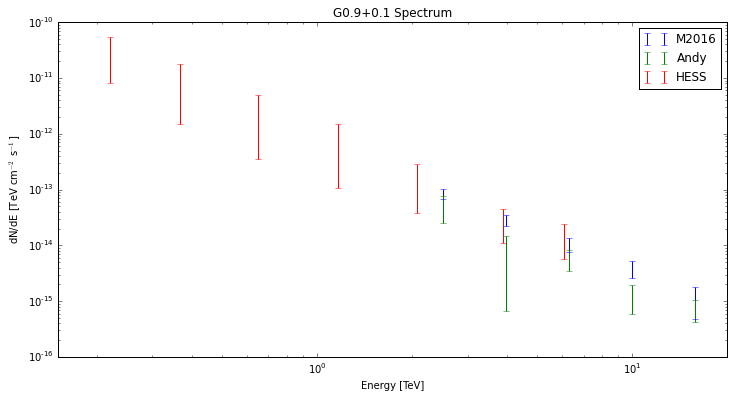

In [49]:
power = 2.
# all energies in TeV 
G09_points_M2016 = astropy.io.ascii.read(gc_dir+"/spectralPoints/G09+01_allOff_spectralPoints.txt")
G09_points_Andy = astropy.io.ascii.read(gc_dir+"spectralPoints/G09+01_Andy_spectral_points_E2-ergs.txt")
G09_points_HESS = astropy.io.ascii.read(gc_dir+"/spectralPoints/G09+01_HESS_spectrum_2005_points.csv")

# convert m^-2 to cm^-2 
G09_points_M2016['col2'] *= 1e-4
G09_points_M2016['col3'] *= 1e-4

print(G09_points_HESS)

plt.errorbar(G09_points_M2016['col1'], G09_points_M2016['col2'], G09_points_M2016['col3'], 
            label='M2016', ls='')
plt.errorbar(G09_points_Andy['col1'], G09_points_Andy['col2'], G09_points_Andy['col3'],
            label="Andy", ls='')
plt.errorbar(G09_points_HESS['col1'], G09_points_HESS['col2'], (G09_points_HESS['col4'], G09_points_HESS['col3']),
            label="HESS", ls='')

plt.title("G0.9+0.1 Spectrum ")
plt.loglog(nonposy="clip")
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.xlim(xmin=0.15, xmax=20)
# think this is just dN/dE
plt.ylabel(r"dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

#plt.savefig(gc_dir+"/plots/spectra/G09_spectra_HESSoverlay_wAndy.png")



parameters:
[-28.15383586  -2.58952104]
covariance matrix
[[ 1433.68340047  -619.74404165]
 [ -619.74404165   309.13835126]]
0.534023119906


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


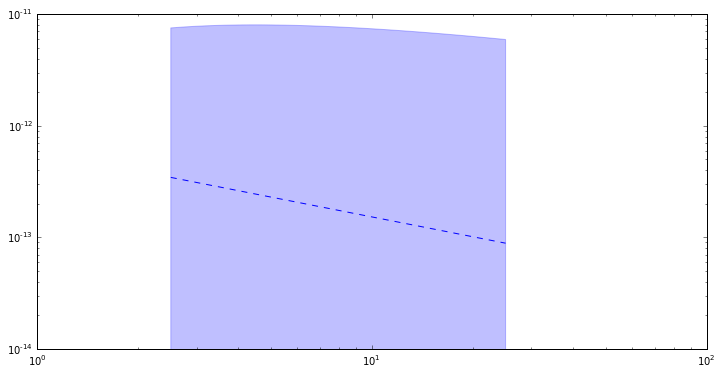

In [23]:
plotPythonFit(G09_points_M2016['col1'], G09_points_M2016['col2'], G09_points_M2016['col3'], 
                'blue', name='M2016')


<h2> Disp 5t / LZA / Crab Validation

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


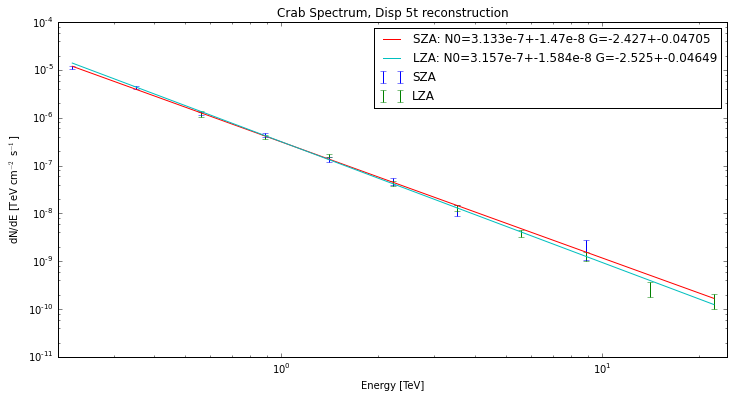

In [63]:

crab_dir = home + "/Dropbox/VEGAS/Crab"
sza_points = np.genfromtxt(crab_dir+"/results/spectral_points_Crab_SZA.txt")
lza_points = np.genfromtxt(crab_dir+"/results/spectral_points_Crab_LZA.txt")
# :,0 gives energy - then flux, error 

plt.errorbar(sza_points[:,0], sza_points[:,1], sza_points[:,2], label='SZA', ls='', c='blue')
plt.errorbar(lza_points[:,0], lza_points[:,1], lza_points[:,2], label='LZA', ls='', c='green')
plt.title("Crab Spectrum, Disp 5t reconstruction")
plt.xlabel("Energy [TeV]")
plt.xlim(0.9*sza_points[0,0], 1.1*lza_points[-1,0])
plt.ylabel(r"dN/dE [TeV cm$^{-2}$ s$^{-1}$]")
plt.loglog()

E = np.linspace(sza_points[0,0], lza_points[-1,0], 100)
# fit parameters from VEGAS output 
flux_sza = 3.133e-7 * np.power(E, -2.427)
flux_lza = 3.157e-7 * np.power(E, -2.525)
plt.plot(E, flux_sza, c='blue', ls='-', marker='', label="SZA: N0=3.133e-7+-1.47e-8 G=-2.427+-0.04705")
plt.plot(E, flux_lza, c='green', ls='-', marker='', label="LZA: N0=3.157e-7+-1.584e-8 G=-2.525+-0.04649")

plt.legend(loc="best")
plt.savefig(crab_dir+"/plots/Crab_V6_disp5t_SZAvLZA_spectrum.png")
